# 한글 스팸 이메일 분류

## 1. 데이터 불러오기
## 2. 피처 엔지니어링 (5개 이상의 피처를 생성)
## 3. 탐색적 데이터 분석(EDA)을 통한 시각화
## 4. 학습 및 테스트 데이터 분할
## 5. 여러 분류 모델(Decision Tree, XGBoost, Logistic Regression 등)로 학습
## 6. 모델 성능 비교 및 시각화
## 7. 사용자 입력에 대한 스팸 여부 예측 함수 작성

In [65]:
%pip install pandas googletrans==4.0.0-rc1 numpy scikit-learn xgboost matplotlib seaborn

Note: you may need to restart the kernel to use updated packages.


In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier


## 0. 데이터 수집

학습에 사용하기 위한 데이터로는 kaggle에 있는 영문 이메일 데이터 셋을 한글로 번역한 데이터와 한글 스팸 이메일 데이터를 사용하였습니다.

In [67]:
import pandas as pd
from googletrans import Translator

In [68]:
# input_csv = 'emails.csv'
# df = pd.read_csv(input_csv)

In [69]:
# # Initialize the translator
# translator = Translator()

# # Define a function to translate text from English to Korean.
# def translate_text(text):
#     try:
#         # Translate the text to Korean (dest='ko')
#         translation = translator.translate(text, dest='ko')
#         return translation.text
#     except Exception as e:
#         print("Error translating text:", text, e)
#         return text

In [70]:
# # Apply the translation function to the "text" column.
# df['text'] = df['text'].apply(translate_text)

# # Save the translated dataset to a new CSV file.
# output_csv = 'spam_translated.csv'
# df.to_csv(output_csv, index=False)
# print("Translation complete. Translated file saved as", output_csv)

# 1. 데이터 개요

In [71]:
import pandas as pd

# Load two CSV files (adjust file names/paths as needed)
df1 = pd.read_csv('spam_translated.csv')
df2 = pd.read_csv('collected_spam_email.csv')

# Concatenate the two DataFrames into one dataset
df = pd.concat([df1, df2], ignore_index=True)

print("First 5 rows of the combined dataset:")
print(df.head())

print("\nData types and missing value info:")
df.info()

print("\nNumber of missing values per column:")
print(df.isnull().sum())

print("\nStatistical summary of numeric features:")
print(df.describe())

First 5 rows of the combined dataset:
                                                text  spam
0  제목 : 자연스럽게 저항 할 수없는 회사의 정체성 LT는 회사를 회상하기가 정말 어...     1
1  주제 : 주식 거래 총잡이 패니는 메릴이지만 콜자 아스트레더가 아니라 콜자가 아닌 ...     1
2  제목 : 믿을 수없는 새 주택은 당신에게 미리 454 달러, 169 달러의 주택 융...     1
3  제목 : 4 컬러 인쇄 특별 요청 추가 정보!여기를 클릭하여 여기를 클릭하십시오. ...     1
4  제목 : 돈이없고 여기에서 소프트웨어 CD를 얻으십시오!소프트웨어 호환성....대단...     1

Data types and missing value info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5734 entries, 0 to 5733
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    5734 non-null   object
 1   spam    5734 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 89.7+ KB

Number of missing values per column:
text    0
spam    0
dtype: int64

Statistical summary of numeric features:
              spam
count  5734.000000
mean      0.239623
std       0.426891
min       0.000000
25%       0.000000
50%       0.000000
75%       0.000000
max   

# 2. 피처 엔지니어링

- **메일 길이:** 전체 문자 수  
- **단어 수:** 공백을 기준으로 한 단어 수  
- **숫자 수:** 0-9 숫자의 등장 횟수  
- **특수문자 수:** 지정된 특수문자(!, ?, @, #, $, %, ^, &, *, (, )) 등장 횟수  
- **스팸 키워드 포함 횟수:** "무료", "당첨", "이벤트" 등 스팸에 자주 등장하는 단어들의 등장 횟수  
- **한글 비율:** 전체 문자 대비 한글(가-힣) 문자의 비율  
- **연속 반복 문자 수:** 같은 문자가 3번 이상 반복되는 패턴의 개수

In [72]:
import re

def feature_engineering(df):
    # 메일 길이
    df['length'] = df['text'].apply(len)
    
    # 단어 수
    df['word_count'] = df['text'].apply(lambda x: len(x.split()))
    
    # 숫자 수
    df['num_digits'] = df['text'].apply(lambda x: sum(c.isdigit() for c in x))
    
    # 특수문자 수 (예: !, ?, @, #, $, %, ^, &, *, (, ))
    special_chars = set(['!', '?', '@', '#', '$', '%', '^', '&', '*', '(', ')'])
    df['num_special_chars'] = df['text'].apply(lambda x: sum(c in special_chars for c in x))
    
    # 스팸 키워드 포함 횟수
    spam_keywords = ["무료", "당첨", "이벤트", "광고", "회원", "대출", "카드", "보상", "긴급", "특가", "약물", "투자", "주식", "성인", "배팅", "도박", "채용", "지원", "VIP", "vip", "혜택", "할인", "무료", "당첨", "이벤트", "광고", "회원", "대출", "카드", "보상", "긴급", "특가", "약물", "투자", "주식", "성인", "배팅", "도박", "채용", "지원", "VIP", "vip", "혜택", "할인"]
    def count_spam_keywords(text):
        count = 0
        for kw in spam_keywords:
            count += text.count(kw)
        return count
    df['num_spam_keywords'] = df['text'].apply(count_spam_keywords)
    
    # 한글 비율: 전체 문자 대비 한글(가-힣) 문자 비율
    def hangul_ratio(text):
        total = len(text)
        if total == 0:
            return 0
        count_hangul = sum(1 for c in text if '가' <= c <= '힣')
        return count_hangul / total
    df['hangul_ratio'] = df['text'].apply(hangul_ratio)
    
    # 연속 반복 문자 수 (같은 문자가 3번 이상 반복되는 경우)
    def count_repeated_sequences(text):
        matches = re.findall(r'(.)\1\1+', text)
        return len(matches)
    df['repeated_seq'] = df['text'].apply(count_repeated_sequences)
    
    return df

# 피처 엔지니어링 적용
df = feature_engineering(df)

df.head()

,text,spam,length,word_count,num_digits,num_special_chars,num_spam_keywords,hangul_ratio,repeated_seq
0,제목 : 자연스럽게 저항 할 수없는 회사의 정체성 LT는 회사를 회상하기가 정말 어...,1,817,241,4,1,2,0.450428,1
1,주제 : 주식 거래 총잡이 패니는 메릴이지만 콜자 아스트레더가 아니라 콜자가 아닌 ...,1,287,59,0,0,2,0.466899,0
2,"제목 : 믿을 수없는 새 주택은 당신에게 미리 454 달러, 169 달러의 주택 융...",1,215,53,9,0,0,0.627907,0
3,제목 : 4 컬러 인쇄 특별 요청 추가 정보!여기를 클릭하여 여기를 클릭하십시오. ...,1,299,62,30,12,2,0.354515,0
4,제목 : 돈이없고 여기에서 소프트웨어 CD를 얻으십시오!소프트웨어 호환성....대단...,1,113,21,0,2,0,0.716814,1


# 3. 탐색적 데이터 분석(EDA)
기본적인 스팸/비스팸 분포 및 생성한 피처에 대한 분포를 시각화합니다.

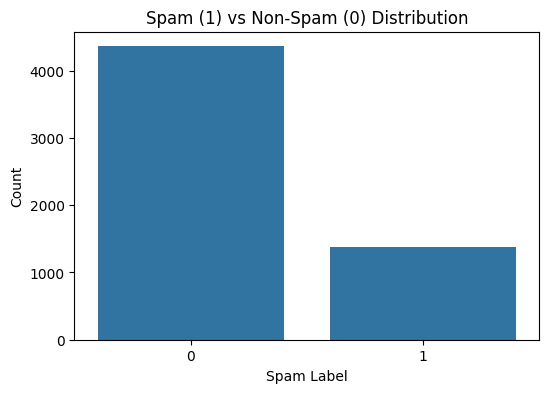

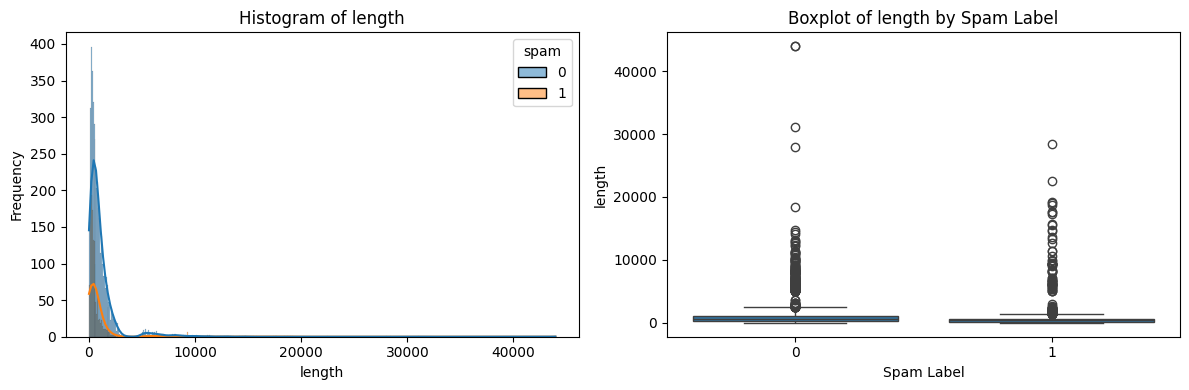

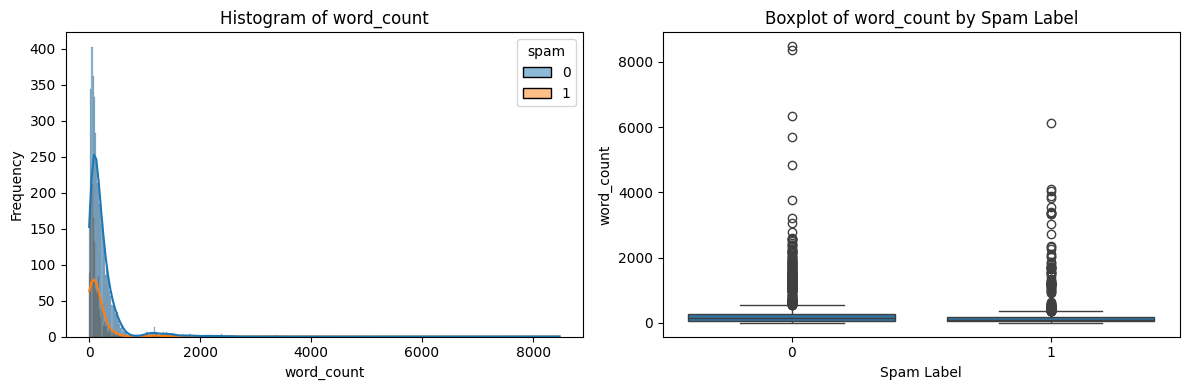

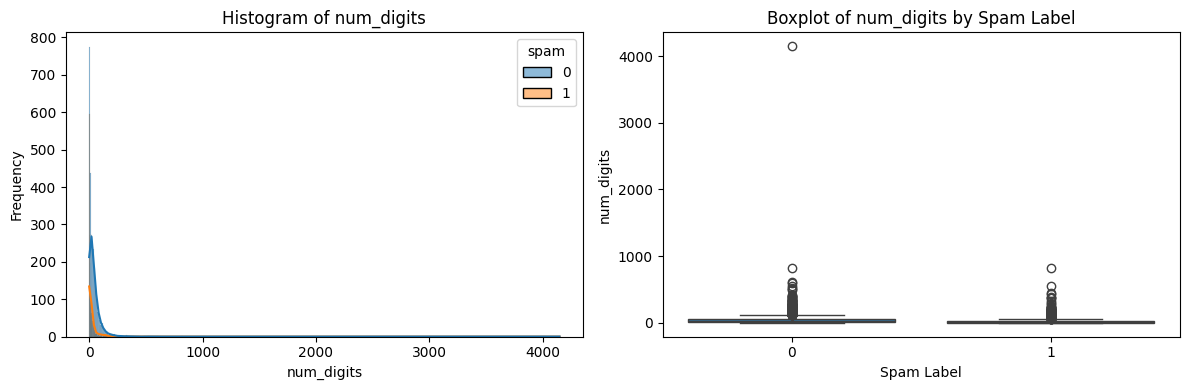

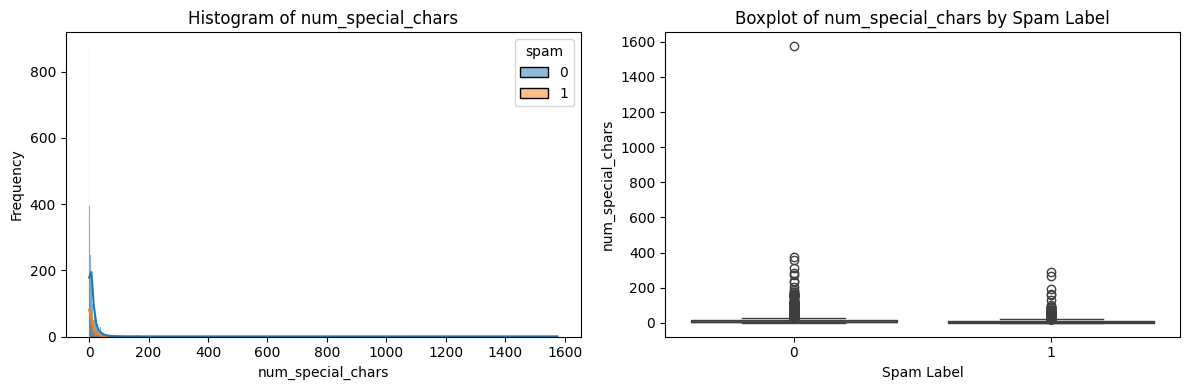

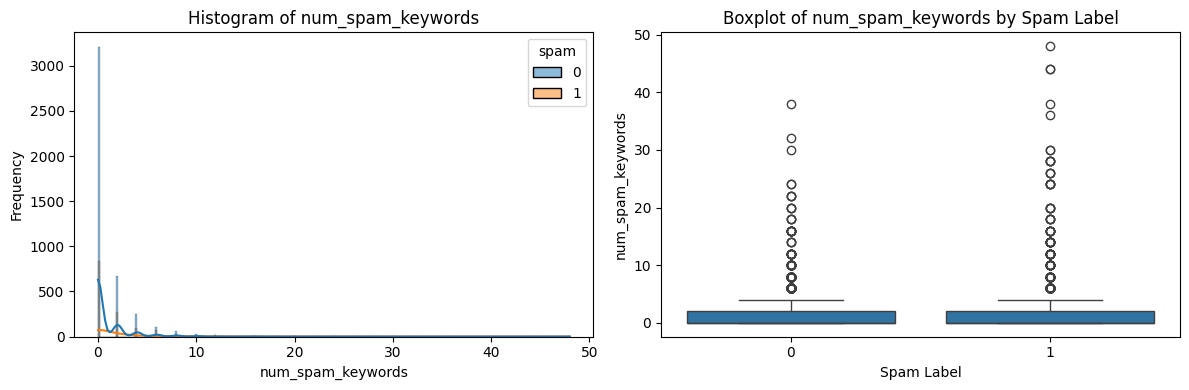

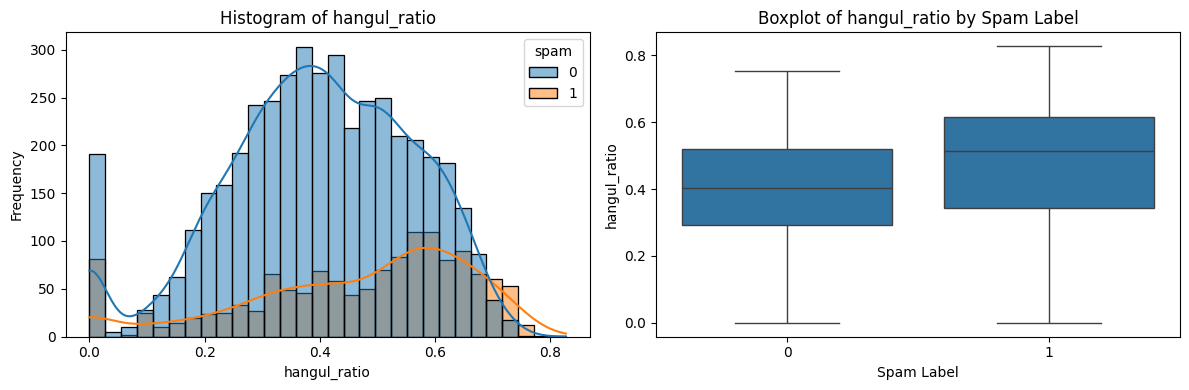

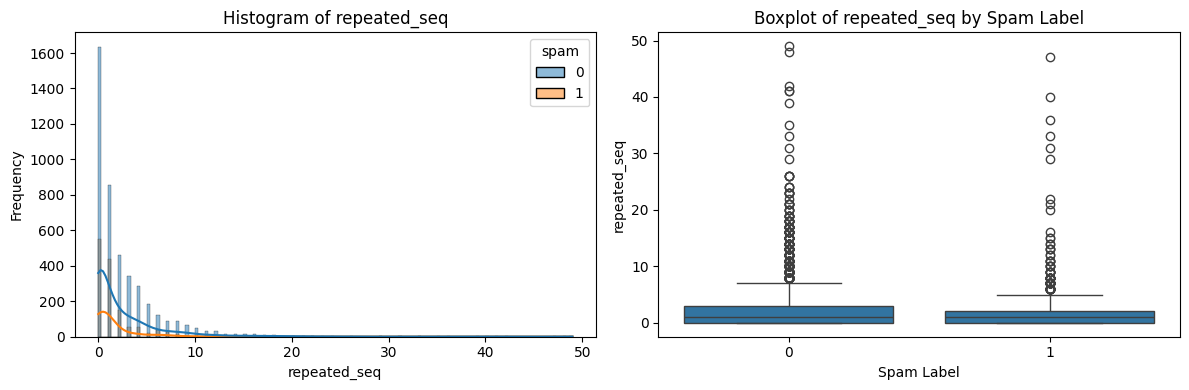

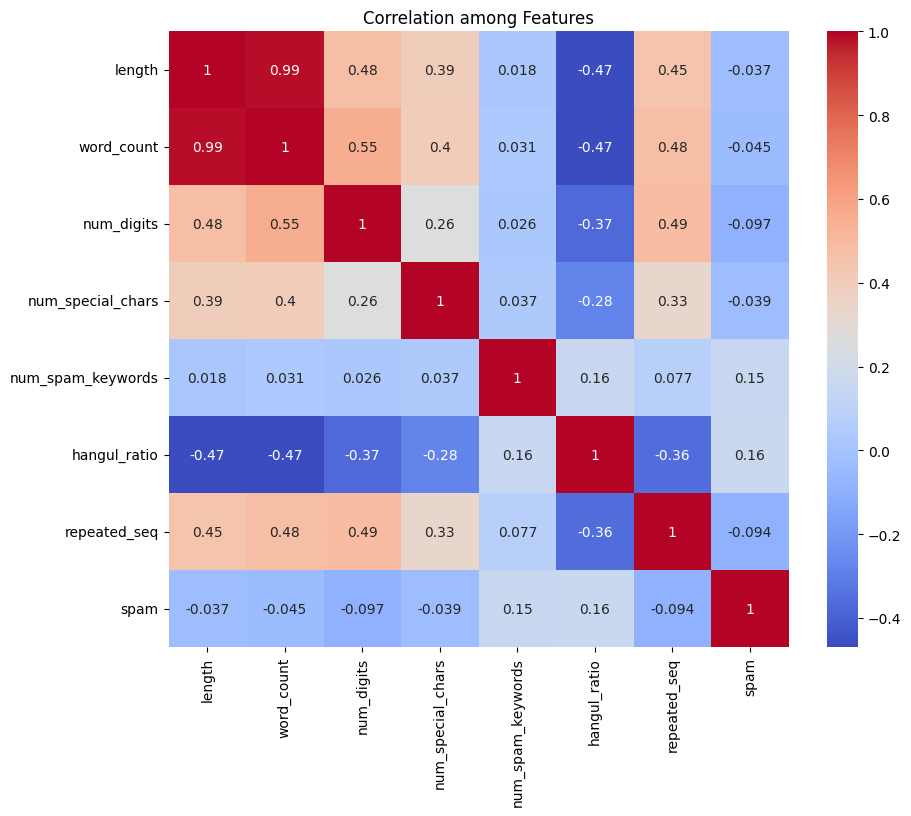

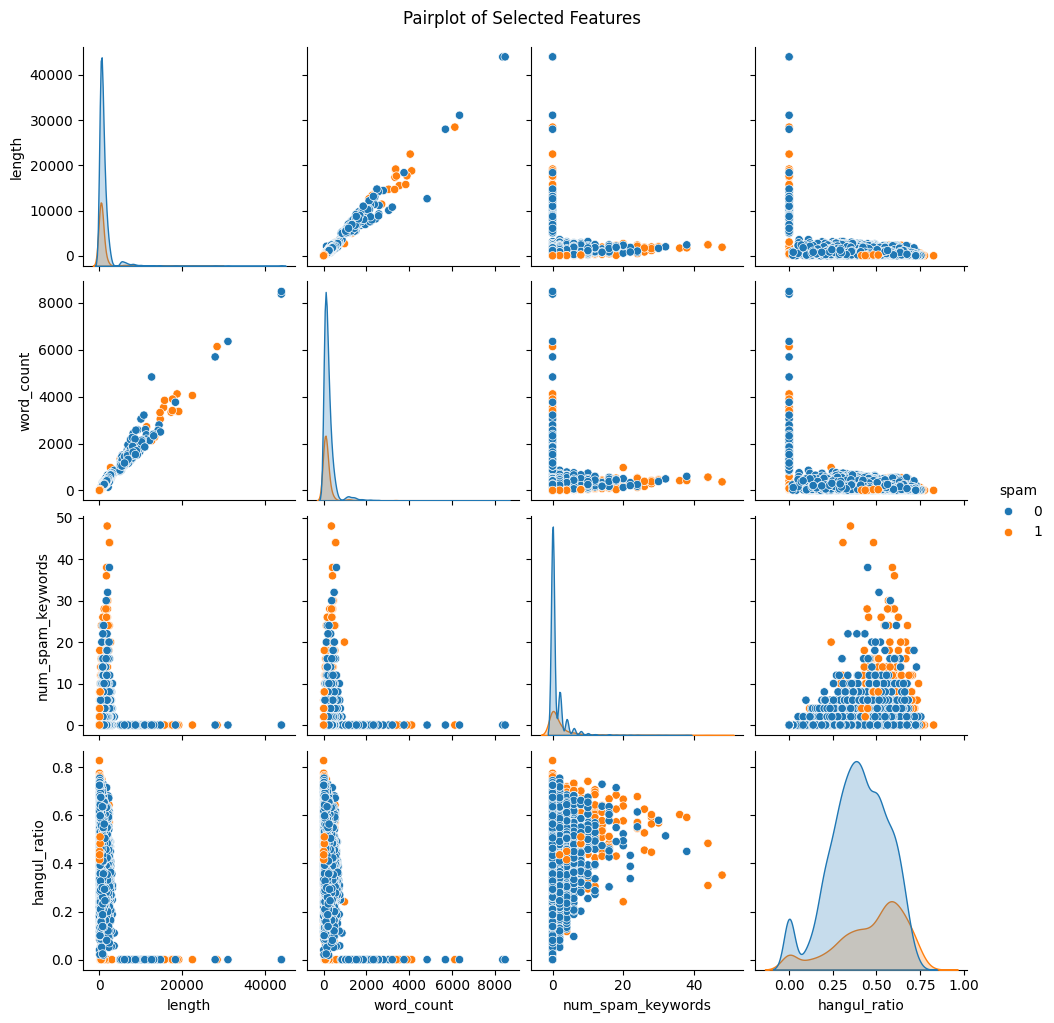

In [73]:
import matplotlib.pyplot as plt
import seaborn as sns

# Distribution of Spam (1) vs Non-Spam (0)
plt.figure(figsize=(6,4))
sns.countplot(x='spam', data=df)
plt.title("Spam (1) vs Non-Spam (0) Distribution")
plt.xlabel("Spam Label")
plt.ylabel("Count")
plt.show()

# %%
# Histograms and Boxplots for each feature
features_to_plot = ['length', 'word_count', 'num_digits', 'num_special_chars', 
                    'num_spam_keywords', 'hangul_ratio', 'repeated_seq']
for feature in features_to_plot:
    fig, ax = plt.subplots(1, 2, figsize=(12,4))
    
    # Histogram
    sns.histplot(data=df, x=feature, hue='spam', kde=True, ax=ax[0])
    ax[0].set_title(f"Histogram of {feature}")
    ax[0].set_xlabel(feature)
    ax[0].set_ylabel("Frequency")
    
    # Boxplot
    sns.boxplot(x='spam', y=feature, data=df, ax=ax[1])
    ax[1].set_title(f"Boxplot of {feature} by Spam Label")
    ax[1].set_xlabel("Spam Label")
    ax[1].set_ylabel(feature)
    
    plt.tight_layout()
    plt.show()

# %%
# Correlation Heatmap among features
plt.figure(figsize=(10,8))
corr = df[['length','word_count','num_digits','num_special_chars',
           'num_spam_keywords','hangul_ratio','repeated_seq','spam']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Correlation among Features")
plt.show()

# %%
# Pairplot for selected features
sns.pairplot(df[['length','word_count','num_spam_keywords','hangul_ratio','spam']], hue='spam')
plt.suptitle("Pairplot of Selected Features", y=1.02)
plt.show()

# 4. 학습 및 테스트 데이터 분할
**Feature(피처)**: 위에서 생성한 수치형 피처들  
**Target(타겟)**: `spam` (0: 비스팸, 1: 스팸)

위의 각 feature들을 시각화한 결과 'num_spam_keyword', 'num_special_chars', 'repeated_seq'가 스팸 여부를 판단하는데 가장 중요한 피처로 보입니다.

In [74]:
from sklearn.model_selection import train_test_split

# Feature list from Section 2
feature_cols = ['num_spam_keywords', 'num_special_chars', 'repeated_seq', 'word_count']

X = df[feature_cols]
y = df['spam']

# Split the data (80:20, with stratification to maintain class proportions)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print("Training set shape:", X_train.shape, "Test set shape:", X_test.shape)

Training set shape: (4587, 4) Test set shape: (1147, 4)


# 5. 여러 분류 모델 학습 및 비교
학습을 위해 다음 5가지 모델들을 사용합니다.

1) Decision Tree  
2) Random Forest  
3) XGBoost  
4) Logistic Regression  
5) Support Vector Machine (SVM)

In [75]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

models = {
    "DecisionTree": DecisionTreeClassifier(random_state=42),
    "RandomForest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(eval_metric='logloss', random_state=42),
    "LogisticRegression": LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced'),
    "SVM": SVC(probability=True, random_state=42, class_weight='balanced')
}

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    results[name] = acc
    print(f"=== {name} ===")
    print("Accuracy:", acc)
    print("Classification Report:")
    print(classification_report(y_test, y_pred, zero_division=0))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print()
    print("=====================================")

=== DecisionTree ===
Accuracy: 0.7750653879686138
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.87      0.86       872
           1       0.54      0.46      0.50       275

    accuracy                           0.78      1147
   macro avg       0.69      0.67      0.68      1147
weighted avg       0.77      0.78      0.77      1147

Confusion Matrix:
[[762 110]
 [148 127]]

=== RandomForest ===
Accuracy: 0.7986050566695728
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.91      0.87       872
           1       0.61      0.45      0.52       275

    accuracy                           0.80      1147
   macro avg       0.72      0.68      0.70      1147
weighted avg       0.78      0.80      0.79      1147

Confusion Matrix:
[[792  80]
 [151 124]]

=== XGBoost ===
Accuracy: 0.8012205754141238
Classification Report:
              precision    recall  f1-score   su

# 6. 모델 성능 비교 및 시각화
테스트한 5개의 모델의 결과를 accuracy를 기준으로 비교합니다.

/tmp/ipykernel_199516/313976344.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=model_names, y=accuracy_scores, palette='viridis')


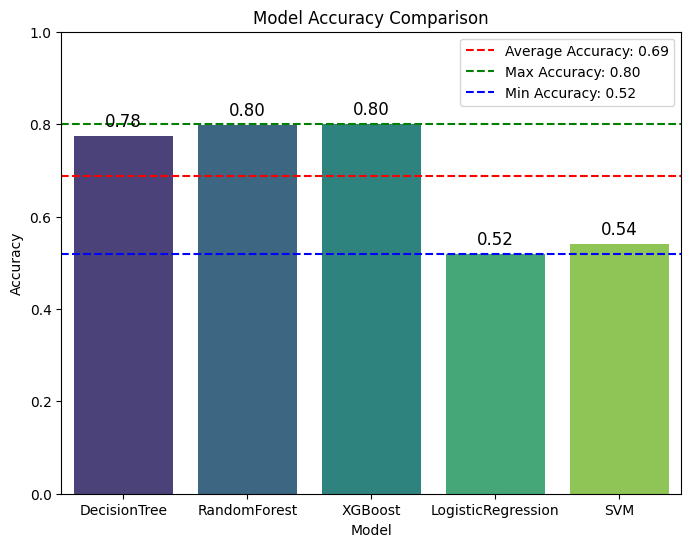

Model Accuracy Summary:
Average Accuracy: 0.6870
Max Accuracy: 0.8012
Min Accuracy: 0.5187

Best model: XGBoost (Accuracy: 0.8012)


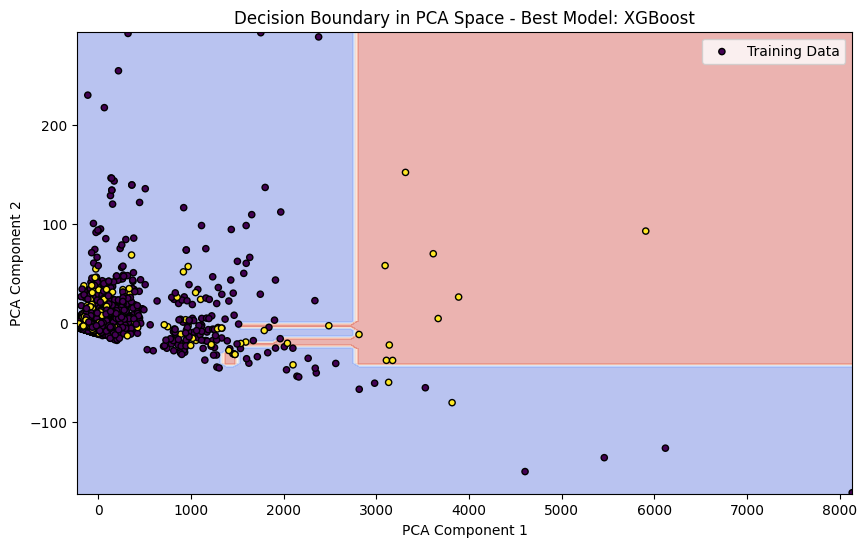

In [76]:
import numpy as np

# Calculate summary statistics for model accuracies
model_names = list(results.keys())
accuracy_scores = list(results.values())

avg_accuracy = np.mean(accuracy_scores)
max_accuracy = np.max(accuracy_scores)
min_accuracy = np.min(accuracy_scores)

plt.figure(figsize=(8,6))
sns.barplot(x=model_names, y=accuracy_scores, palette='viridis')
plt.title("Model Accuracy Comparison")
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.ylim(0, 1.0)
for i, v in enumerate(accuracy_scores):
    plt.text(i, v+0.02, f"{v:.2f}", ha='center', fontsize=12)

# Plot horizontal lines for average, maximum, and minimum accuracy
plt.axhline(avg_accuracy, color='red', linestyle='--', label=f"Average Accuracy: {avg_accuracy:.2f}")
plt.axhline(max_accuracy, color='green', linestyle='--', label=f"Max Accuracy: {max_accuracy:.2f}")
plt.axhline(min_accuracy, color='blue', linestyle='--', label=f"Min Accuracy: {min_accuracy:.2f}")
plt.legend()
plt.show()

print("Model Accuracy Summary:")
print(f"Average Accuracy: {avg_accuracy:.4f}")
print(f"Max Accuracy: {max_accuracy:.4f}")
print(f"Min Accuracy: {min_accuracy:.4f}")

# %%
# Decision Boundary Visualization for the Best Model
from sklearn.decomposition import PCA
from sklearn.base import clone

best_model_name = max(results, key=results.get)
best_model_score = results[best_model_name]
print(f"\nBest model: {best_model_name} (Accuracy: {best_model_score:.4f})")

# Retrieve the best model from the dictionary
best_model = models[best_model_name]

# Reduce feature space to 2 dimensions using PCA
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Clone and retrain the best model on the PCA-transformed data for visualization
best_model_2d = clone(best_model)
best_model_2d.fit(X_train_pca, y_train)

# Create a mesh grid using np.linspace to control the number of points (e.g., 100 points per axis)
x_min, x_max = X_train_pca[:, 0].min() - 1, X_train_pca[:, 0].max() + 1
y_min, y_max = X_train_pca[:, 1].min() - 1, X_train_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, num=100),
                     np.linspace(y_min, y_max, num=100))

# Predict for each point in the mesh grid
Z = best_model_2d.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(10,6))
plt.contourf(xx, yy, Z, alpha=0.4, cmap=plt.cm.coolwarm)
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, s=20, edgecolor='k', label='Training Data')
plt.title(f"Decision Boundary in PCA Space - Best Model: {best_model_name}")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.show()

측정 결과 random forest와 xgboost가 85~87%로 가장 높은 정확도를 보였습니다.

해당 모델의 트레이닝에 사용된 데이터 셋이 영문 이메일들을 한글로 번역하여 사용한것이기 대부분이기에 충분한 한글로 된 데이터 셋이 있다면 더 좋은 결과가 나올것으로 생각됩니다.

# 7. 사용자 입력에 대한 스팸 여부 예측 함수
아래 함수를 통해, 사용자가 새로운 한국어 이메일 내용을 입력하면 바로 스팸 여부(0/1)를 예측할 수 있습니다.

In [77]:
best_model = models[best_model_name]

def predict_spam(input_text):
    """
    사용자로부터 이메일 내용을 입력받아 스팸 여부를 예측하는 함수.
    """
    temp_df = pd.DataFrame({'text': [input_text]})
    temp_df = feature_engineering(temp_df)
    
    # 모델에 필요한 피처만 추출
    temp_X = temp_df[feature_cols]
    
    pred = best_model.predict(temp_X)[0]
    return pred  # 0이면 비스팸, 1이면 스팸

# 함수 테스트
test_email = """
(광고) 위메프플러스 앱 설치하고 W 포인트 2배 적립! 최대 10,000P 혜택 과 네이버페이 추가할인까지! [농협안심한우 1등급 구이용 등심 500g&불고기 500g+500g 골라담기 30,000원/ 온천수 저염 반숙계란 20구 9,900원/ 전라도 꿀고구마 3kg/5kg 8,170원] 등 인기상품들을 특가로 득템하세요!
"""
result = predict_spam(test_email)
print(f"이메일 내용: {test_email}")
print("예측 결과:", "스팸" if result == 1 else "비스팸")

이메일 내용: 
(광고) 위메프플러스 앱 설치하고 W 포인트 2배 적립! 최대 10,000P 혜택 과 네이버페이 추가할인까지! [농협안심한우 1등급 구이용 등심 500g&불고기 500g+500g 골라담기 30,000원/ 온천수 저염 반숙계란 20구 9,900원/ 전라도 꿀고구마 3kg/5kg 8,170원] 등 인기상품들을 특가로 득템하세요!

예측 결과: 스팸
